# <CENTER>LeNet5手写数字识别作业</CENTER>

#### <CENTER>高朗 U202115641 计科2110班</CENTER>

## 2.2.1 环境准备
MindSpore模块主要用于本次实验卷积神经网络的构建，包括很多子模块。
- mindspore.dataset：包括MNIST数据集的载入与处理，也可以自定义数据集。
- mindspore.common：包中会有诸如type形态转变、权重初始化等的常规工具。
- mindspore.nn：主要包括网络可能涉及到的各类网络层，诸如卷积层、池化层、全连接层，也包括损失函数，激活函数等。
- Model：承载网络结构，并能够调用优化器、损失函数、评价指标。 

In [1]:
import mindspore
from mindspore import dtype
from mindspore import context
from mindspore.dataset import MnistDataset
from mindspore.dataset.vision import Resize, Rescale, HWC2CHW
from mindspore.dataset.transforms import TypeCast
from mindspore import nn
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore.train import Model
from mindspore.nn.metrics import Accuracy

[WARNING] ME(14649:140114932912768,MainProcess):2023-10-28-15:13:12.608.581 [mindspore/run_check/_check_version.py:102] MindSpore version 2.2.0 and cuda version 11.4.148 does not match, CUDA version [['10.1', '11.1', '11.6']] are supported by MindSpore officially. Please refer to the installation guide for version matching information: https://www.mindspore.cn/install.


## 2.2.2 数据处理 
定义数据预处理函数。
函数功能包括：
1. 加载数据集
2. 打乱数据集
3. 图像特征处理（标准化、通道转换等）
4. 批量输出数据
5. 重复

- 打印数据集列名

In [2]:
train_dataset = MnistDataset('MNIST/train')
test_dataset = MnistDataset('MNIST/test')
print(train_dataset.get_col_names()) # 打印数据集中包含的数据列名，用于 dataset 的预处理

['image', 'label']


- 使用create_tuple_iterator对数据集进行迭代，打印数据集shape

In [3]:
for image, label in test_dataset.create_tuple_iterator():
    print(f"Shape of image [N, C, H, W]: {image.shape} {image.dtype}")
    print(f"Shape of label: {label.shape} {label.dtype}")
    break

Shape of image [N, C, H, W]: (28, 28, 1) UInt8
Shape of label: () UInt32


- 数据预处理函数实现

In [6]:
def create_dataset(data_path, batch_size=32, num_parallel_workers=1):
    """
    create dataset for train or test
    """
    # define dataset
    mnist_ds = MnistDataset(data_path)
    resize_height, resize_width = 32, 32
    rescale = 1.0 /255.0
    rescale_nml = 1 /0.3081
    shift_nml = -1 * 0.1307 / 0.3081
    # define map operations
    resize_op = Resize((resize_height, resize_width)) # Bilinear mode
    rescale_nml_op = Rescale(rescale_nml * rescale, shift_nml)
    hwc2chw_op = HWC2CHW()
    type_cast_op = TypeCast(dtype.int32)
    # apply map operations on images
    mnist_ds = mnist_ds.map(operations=type_cast_op, input_columns="label",
                            num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=resize_op, input_columns="image",num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_nml_op, input_columns="image",num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=hwc2chw_op, input_columns="image",num_parallel_workers=num_parallel_workers)
    # apply DatasetOps
    mnist_ds = mnist_ds.shuffle(buffer_size=1024)
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    return mnist_ds

- 加载训练数据集，并打印数据shape

In [8]:
ds_train = create_dataset("./MNIST/train", 32)
for data in ds_train.create_dict_iterator():
    print(f"Shape of image [N, C, H, W]: {data['image'].shape} {data['image'].dtype}")
    print(f"Shape of label: {data[ 'label'].shape} {data['label'].dtype}")
    break

Shape of image [N, C, H, W]: (32, 1, 32, 32) Float32
Shape of label: (32,) Int32


## 2.2.3 网络定义
参考LeNet网络结构，构建网络：

LeNet-5出自论文《Gradient-Based Learning Applied to Document Recognition》，原本是一种用于手写体字符识别的非常高效的卷积神经网络，包含了深度学习的基本模块：卷积层，池化层，全连接层。

mindspore.nn类是构建所有网络的基类，也是网络的基本单元。当用户需要自定义网络时，可以继承nn.Cell类，并重写__init__方法和construct方法。__init__包含所有网络层的定义，construct中包含数据（Tensor）的变换过程（即计算图的构造过程）

In [20]:
import mindspore.nn as nn
class LeNet5(nn.Cell):
    """
    LeNet5网络结构 
    """
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        # 卷积层，输入的通道数为 num_channel，输出的通道数为 6，卷积核大小为 5*5
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        # 卷积层，输入的通道数为 6，输出的通道数为 16，卷积核大小为 5*5
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        #全连接层，输入个数为 16*5*5，输出个数为 120
        self.fc1 = nn.Dense(16* 5 * 5, 120)
        # 全连接层，输入个数为 120，输出个数为 84
        self.fc2 = nn.Dense(120, 84)
        #全连接层，输入个数为 84，分类的个数为 num class
        self.fc3 = nn.Dense(84, num_class)
        # ReLU 激活函数
        self.relu = nn.ReLU()
        # 池化层
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        #多维数组展平为一维数组
        self.flatten = nn.Flatten()
    def construct(self, x):
        # 使用定义好的运算构建前向网络
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
model = LeNet5()

- 实例化LeNet5对象，并查看其结构

In [21]:
print(model)

LeNet5<
  (conv1): Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.HeUniform object at 0x7f6edbfd7580>, bias_init=None, format=NCHW>
  (conv2): Conv2d<input_channels=6, output_channels=16, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.HeUniform object at 0x7f6edbfd7a90>, bias_init=None, format=NCHW>
  (fc1): Dense<input_channels=400, output_channels=120, has_bias=True>
  (fc2): Dense<input_channels=120, output_channels=84, has_bias=True>
  (fc3): Dense<input_channels=84, output_channels=10, has_bias=True>
  (relu): ReLU<>
  (max_pool2d): MaxPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (flatten): Flatten<>
  >


## 2.2.4 模型训练
载入数据集 

构建网络，包含：构建网络、选择损失函数、优化器、模型

训练模型

In [25]:
context.set_context(mode=context.GRAPH_MODE)
ds_train = create_dataset("./MNIST/train", 32)
network = LeNet5(10)
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
net_opt = nn.Momentum(network.trainable_params(), 0.01, 0.9)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
config_ck = CheckpointConfig(save_checkpoint_steps=1875,keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint lenet", directory="./", config=config_ck)
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})
print("============== Starting Training ==============")
model.train(10, ds_train, callbacks=[time_cb, ckpoint_cb, LossMonitor()], dataset_sink_mode=True)

============== Starting Training ==============
epoch: 1 step: 1875, loss is 0.022805936634540558
Train epoch time: 11468.204 ms, per step time: 6.116 ms
epoch: 2 step: 1875, loss is 0.04516192153096199
Train epoch time: 2172.446 ms, per step time: 1.159 ms
epoch: 3 step: 1875, loss is 0.010889369994401932
Train epoch time: 2166.698 ms, per step time: 1.156 ms
epoch: 4 step: 1875, loss is 0.002444074722006917
Train epoch time: 2186.845 ms, per step time: 1.166 ms
epoch: 5 step: 1875, loss is 0.056051403284072876
Train epoch time: 2165.922 ms, per step time: 1.155 ms
epoch: 6 step: 1875, loss is 0.0038104818668216467
Train epoch time: 2150.983 ms, per step time: 1.147 ms
epoch: 7 step: 1875, loss is 0.010055968537926674
Train epoch time: 2190.602 ms, per step time: 1.168 ms
epoch: 8 step: 1875, loss is 0.049697134643793106
Train epoch time: 2161.336 ms, per step time: 1.153 ms
epoch: 9 step: 1875, loss is 0.013900700956583023
Train epoch time: 2148.155 ms, per step time: 1.146 ms
epoch:

## 2.2.5 模型评估
查看模型在测试集的准确率

In [27]:
from mindspore.train.serialization import load_checkpoint, load_param_into_net
network = LeNet5(10)
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
model = Model(network, net_loss, metrics={"Accuracy": Accuracy()})

print("============== Starting Testing ==============")
param_dict = load_checkpoint("checkpoint lenet-10_1875.ckpt")
load_param_into_net(network, param_dict)
ds_eval = create_dataset("./MNIST/test", 32)
acc = model.eval(ds_eval)
print("============== {} ==============".format(acc))

============== Starting Testing ==============
============== {'Accuracy': 0.9900841346153846} ==============


## 2.2.6 效果展示

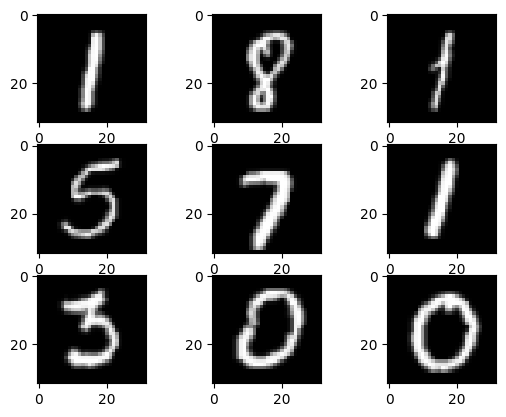

Predicted: "[1 8 1 5 7 1 3 0 0]", Labels: ""[1 8 1 5 7 1 3 0 0]""


[ERROR] CORE(14649,7f6f0ccdd280,python):2023-10-28-15:31:00.560.246 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_14649/4207191589.py]
[ERROR] CORE(14649,7f6f0ccdd280,python):2023-10-28-15:31:00.560.292 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_14649/4207191589.py]


In [32]:
import matplotlib.pyplot as plt
import numpy as np
ds_test = create_dataset("./MNIST/test", 9)
ds_test = ds_test.create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()
plt.figure()
for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(images[i-1][0], interpolation="None", cmap="gray")
plt.show()
# 使用函数 model.predict 预测 image 对应分类
output = model.predict(mindspore.Tensor(data['image']))
predicted = np.argmax(output.asnumpy(), axis= 1)# 输出预测分类与实际分类
print(f'Predicted: "{predicted}", Labels: ""{labels}""')

模型导出

In [37]:
from mindspore import Tensor, context, load_checkpoint, load_param_into_net, export

network = LeNet5(10)
# load network checkpoint
param_dict = load_checkpoint("checkpoint lenet-10_1875.ckpt")
load_param_into_net(network, param_dict)

# export network
inputs = Tensor(np.ones([1, 1, 32, 32]), mindspore.float32)  # batch size 1, image height and weight 32
export(network, inputs, file_name="LeNet5", file_format="ONNX")

## 补充内容

#### 2.3 实验总结

本实验介绍了MindSpore在图像数据集上的应用，使用MNIST手写体数据集搭建LeNet5卷积神经网络，让学员熟悉MindSpore的进阶用法，掌握MindSpore开发的流程。

#### 2.4 思考题

1. 请描述MindSpore的基础数据处理流程。

答：数据加载 > shuffle > map > batch > repeat。

2. 定义网络时需要继承哪一个基类？

答：mindspore.nn.Cell。

3. 定义网络时有哪些必须编写哪两个函数？

答：_\_init__()，construct()。

4. 思考3中提到的两个函数有什么用途？

答：一般会在__init__()中定义算子，然后在construct()中定义网络结构。__init__()中的语句由Python解析执行；construct()中的语句由MindSpore接管，有语法限制。